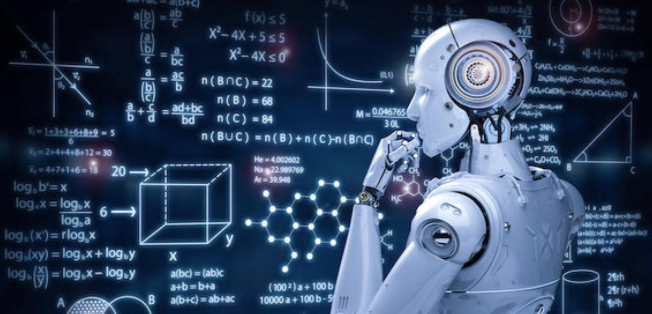

In [ ]:
import numpy as np
import pandas as pd
import math

import plotly
import plotly.express as px
plotly.offline.init_notebook_mode (connected = True)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler

pd.set_option("display.max_columns", None)

# Encoders
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder 
from category_encoders import TargetEncoder, WOEEncoder

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

# Features selection
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
import eli5
from eli5.sklearn import PermutationImportance
import shap

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

import random
import os

SEED = 2021
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.neural_network import MLPClassifier

REGRESSION = False
CLASSIFICATION = True

> # Workflow
> 
> ## EDA
> * [PS-3-3 Fast EDA](https://www.kaggle.com/code/martynovandrey/ps-3-3-fast-eda) - this notebook is based on it.
> 
> ## Preprocessing
> * [PS-3-3 Preprocessing](https://www.kaggle.com/code/martynovandrey/ps-3-3-preprocessing) - the goal is to prepare the same data for the rest of notebooks in one place.
> 
> ## Model selecton
> * [PS-3-3 Model Selection](https://www.kaggle.com/code/martynovandrey/ps-3-3-model-selection)
> 
> ## Models hyperparameters tuning:
> * [PS-3-3 CatBoostClassifier Tuning](https://www.kaggle.com/code/martynovandrey/ps-3-3-catboostclassifier-tuning)
> * [PS-3-3 XGBClassifier Tuning](https://www.kaggle.com/code/martynovandrey/ps-3-3-xgbclassifier-tuning)
> * [PS-3-3 LGBMClassifier Optuna Tuning](https://www.kaggle.com/code/martynovandrey/ps-3-3-lgbmclassifier-optuma-tuning)
> * [PS-3-3 LGBMClassifier Tuning](https://www.kaggle.com/code/martynovandrey/ps-3-3-lgbmclassifier-tuning)
> * [PS-3-3 LogisticRegression Tuning](https://www.kaggle.com/code/martynovandrey/ps-3-3-logisticregression-tuning)
> ## Submission

# Read the data

In [ ]:
train = pd.read_csv('/kaggle/input/ps-3-3-preprocessing/train.csv')
test = pd.read_csv('/kaggle/input/ps-3-3-preprocessing/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e3/sample_submission.csv')
target = 'Attrition'
features = test.columns.to_list()

In [ ]:
def score_clf(clf, df_train, verbose=2, n_folds=10):
    TRAIN = df_train.drop(target, axis=1)
    Y_TRAIN = df_train[target]

    skf = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    train_oof_preds = np.zeros((TRAIN.shape[0],))
    train_oof_probas = np.zeros((TRAIN.shape[0],))

    for fold, (train_index, test_index) in enumerate(skf.split(TRAIN, Y_TRAIN)):
        x_train, x_valid = pd.DataFrame(TRAIN.iloc[train_index]), pd.DataFrame(TRAIN.iloc[test_index])
        y_train, y_valid = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[test_index]
        
        clf.fit(x_train, y_train)
        
        oof_preds = clf.predict(x_valid)
        
        oof_probas = clf.predict_proba(x_valid)[:,1]
        
        train_oof_preds[test_index] = oof_preds
        train_oof_probas[test_index] = oof_probas
      
        auc = roc_auc_score(y_valid, oof_probas)
        if verbose > 1:
            print('Fold', fold, 'auc =', auc)

    AUC = roc_auc_score(Y_TRAIN, train_oof_probas)
    if verbose > 0:
        print('TOTAL', "AUC = ", AUC, '\n')
    
    return AUC, train_oof_probas

    
def show_cv_result(clf, train):
    
    _, probas = score_clf(clf, train)
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 6))
    
    axs[0].hist(probas, density=True, bins=100)
    axs[0].set_title("Probability distribution")
    
    CalibrationDisplay.from_predictions(train[target], probas, n_bins=30, strategy='quantile', ax=axs[1])
    axs[1].set_title('Calibration')
    
    RocCurveDisplay.from_predictions(train[target], probas, ax=axs[2])
    axs[2].set_title('ROC Curve')    

    plt.tight_layout()
    plt.show()   

    
def compare_cv_result(clf0, clf1, train, color0='b', color1='r', label0='Before', label1='After', layout='v', h=12, w=16):
    
    auc0, probas0 = score_clf(clf0, train)
    auc1, probas1 = score_clf(clf1, train)
    
    if layout == 'v':
        fig, axs = plt.subplots(3, 1, figsize=(w, 3*h))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(3*w, h))
    
    sns.kdeplot(probas0, color=color0, label=label0, ax=axs[0])
    sns.kdeplot(probas1, color=color1, label=label1, ax=axs[0])
    axs[0].legend()
    axs[0].set_title("Probability distribution")
    
    CalibrationDisplay.from_predictions(train[target], probas0, n_bins=30, strategy='quantile', ax=axs[1], color=color0, label=label0)
    CalibrationDisplay.from_predictions(train[target], probas1, n_bins=30, strategy='quantile', ax=axs[1], color=color1, label=label1)
    axs[1].set_title('Calibration')
    
    RocCurveDisplay.from_predictions(train[target], probas0, ax=axs[2], color=color0, label=label0)
    RocCurveDisplay.from_predictions(train[target], probas1, ax=axs[2], color=color1, label=label1)
    axs[2].set_title('ROC Curve')    

    plt.tight_layout()
    plt.show()      

# LogisticRegression HyperParameters Tuning

In [ ]:
import optuna

def objective(trial):
    param = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True),
        'C': trial.suggest_float('C', 0.001, 10, log=True),
        'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
        'solver' : trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
    }

    clf = Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression(**param, max_iter=500))])
    auc, _ = score_clf(clf, train, verbose=0, n_folds=3)
    return auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=600)

In [ ]:
print("Number of finished trials:", len(study.trials))
print("\nBest trial:")
trial = study.best_trial
print("  Value: ", trial.value)

optuna_params = trial.params
print("\nParams:")
optuna_params

In [ ]:
compare_cv_result(
    Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression(max_iter=500))]), 
    Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression(**optuna_params, max_iter=500))]), 
    train,
    layout='h', h=6, w=8,
)

# Submission

In [ ]:
est = Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression(**optuna_params, max_iter=500))])

est.fit(train[features], train[target])
probas = est.predict_proba(test)[:, -1]

sample_submission[target] = probas
sample_submission.to_csv("submission.csv", index=False)